In [1]:
!pip install psycopg2-binary
!pip install geopy

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 폰트 설정
mpl.rc('font', family='AppleGothic')  # macOS

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
from geopy.distance import geodesic

In [5]:
# Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# ✅ PostgreSQL 연결 정보
DB_HOST = "14.34.134.108"   # DB ip 주소로 변경해야 함
DB_PORT = "5432"
DB_NAME = "ais_data"
DB_USER = "postgres"
DB_PASS = "ky76018500"

# 엔진 생성
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

 ## 항로 예측 모델을 위한 EDA 

In [9]:
# ais_2020_03 테이블에서 샘플 데이터 30만 개 가져오기
query = """
SELECT * 
FROM ais_2020_03
limit 300000;
"""
df = pd.read_sql(query, engine)
print(df.columns)
# 시간 정렬 및 파싱
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['mmsi', 'timestamp'])

# ✅ 위도(latitude)는 [-90, 90] 범위, 경도(longitude)는 [-180, 180] 범위로 필터링(이상치 처리)
df = df[(df["latitude"].between(-90, 90)) & (df["longitude"].between(-180, 180))]

# 다음 시점 위치/시간
df['next_lat'] = df.groupby('mmsi')['latitude'].shift(-1)
df['next_lon'] = df.groupby('mmsi')['longitude'].shift(-1)
df['next_time'] = df.groupby('mmsi')['timestamp'].shift(-1)

# 거리 계산 (km)
df['distance_km'] = df.apply(
    lambda row: geodesic(
        (row['latitude'], row['longitude']),
        (row['next_lat'], row['next_lon'])
    ).km if pd.notnull(row['next_lat']) else np.nan,
    axis=1
)

# 시간 차이 (시간 단위)
df['delta_time_hr'] = (df['next_time'] - df['timestamp']).dt.total_seconds() / 3600

# 평균 속도 (km/h)
df['avg_speed_kmh'] = df['distance_km'] / df['delta_time_hr']
df

Index(['mmsi', 'timestamp', 'latitude', 'longitude', 'sog', 'cog', 'heading'], dtype='object')


,mmsi,timestamp,latitude,longitude,sog,cog,heading,next_lat,next_lon,next_time,distance_km,delta_time_hr,avg_speed_kmh
190927,/+RXswsrahnv02OzhULX8w==,2020-03-01 00:11:15,33.898018,128.54451,11.0,33.6,34.0,33.904156,128.54950,2020-03-01 00:13:41,0.822523,0.040556,20.281384
190928,/+RXswsrahnv02OzhULX8w==,2020-03-01 00:13:41,33.904156,128.54950,10.9,34.5,35.0,33.930504,128.57062,2020-03-01 00:24:06,3.515065,0.173611,20.246777
190929,/+RXswsrahnv02OzhULX8w==,2020-03-01 00:24:06,33.930504,128.57062,10.8,33.6,33.0,33.934143,128.57350,2020-03-01 00:25:32,0.483561,0.023889,20.242098
190930,/+RXswsrahnv02OzhULX8w==,2020-03-01 00:25:32,33.934143,128.57350,10.9,34.1,33.0,33.941986,128.57968,2020-03-01 00:28:37,1.040801,0.051389,20.253415
190931,/+RXswsrahnv02OzhULX8w==,2020-03-01 00:28:37,33.941986,128.57968,10.9,33.5,34.0,33.945282,128.58226,2020-03-01 00:29:55,0.436518,0.021667,20.146991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208810,z9lTVZWpdLJ2WbyLE8PWZA==,2020-03-01 23:59:04,35.065697,129.00970,0.0,350.0,290.0,35.065697,129.00970,2020-03-01 23:59:14,0.000000,0.002778,0.000000
208811,z9lTVZWpdLJ2WbyLE8PWZA==,2020-03-01 23:59:14,35.065697,129.00970,0.0,350.0,290.0,35.065697,129.00970,2020-03-01 23:59:24,0.000000,0.002778,0.000000
208812,z9lTVZWpdLJ2WbyLE8PWZA==,2020-03-01 23:59:24,35.065697,129.00970,0.0,350.0,290.0,35.065697,129.00970,2020-03-01 23:59:33,0.000000,0.002500,0.000000
208813,z9lTVZWpdLJ2WbyLE8PWZA==,2020-03-01 23:59:33,35.065697,129.00970,0.0,350.0,290.0,35.065697,129.00970,2020-03-01 23:59:44,0.000000,0.003056,0.000000


In [11]:
# 결측치 비율
nulls = df.isnull().mean().sort_values(ascending=False) * 100
print("결측치 비율 (%):")
print(nulls[nulls > 0])

# 통계 요약
print(df[['sog', 'cog', 'heading', 'avg_speed_kmh']].describe())

결측치 비율 (%):
avg_speed_kmh    0.107412
next_lat         0.021624
next_lon         0.021624
next_time        0.021624
distance_km      0.021624
delta_time_hr    0.021624
dtype: float64
                 sog            cog        heading  avg_speed_kmh
count  282092.000000  282092.000000  282092.000000   2.817890e+05
mean        5.017602     167.203481     306.520784            inf
std        10.756212     124.167067     192.801577            NaN
min         0.000000       0.000000       0.000000   0.000000e+00
25%         0.000000      56.700000     112.000000   1.597560e-01
50%         0.000000     177.000000     323.000000   1.372595e+01
75%        10.600000     274.800000     511.000000   2.374254e+01
max       102.300000     409.500000     511.000000            inf


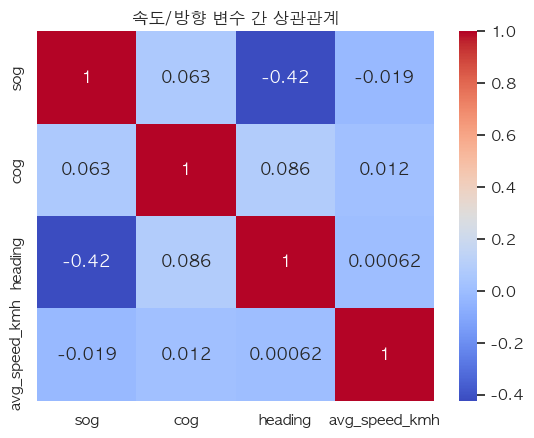

In [17]:
# 상관관계 분석
sns.heatmap(df[['sog', 'cog', 'heading', 'avg_speed_kmh']].corr(), annot=True, cmap='coolwarm')
plt.title("속도/방향 변수 간 상관관계")
plt.show()

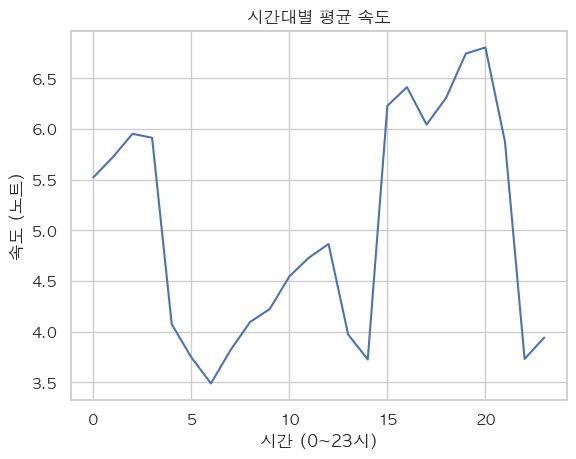

In [19]:
# 시간대별 속도 분석
df['hour'] = df['timestamp'].dt.hour
hourly_speed = df.groupby('hour')['sog'].mean().reset_index()

sns.lineplot(data=hourly_speed, x='hour', y='sog')
plt.title("시간대별 평균 속도")
plt.xlabel("시간 (0~23시)")
plt.ylabel("속도 (노트)")
plt.grid(True)
plt.show()

In [21]:
# 데이터에서 선박 수
df['mmsi'].nunique()

61

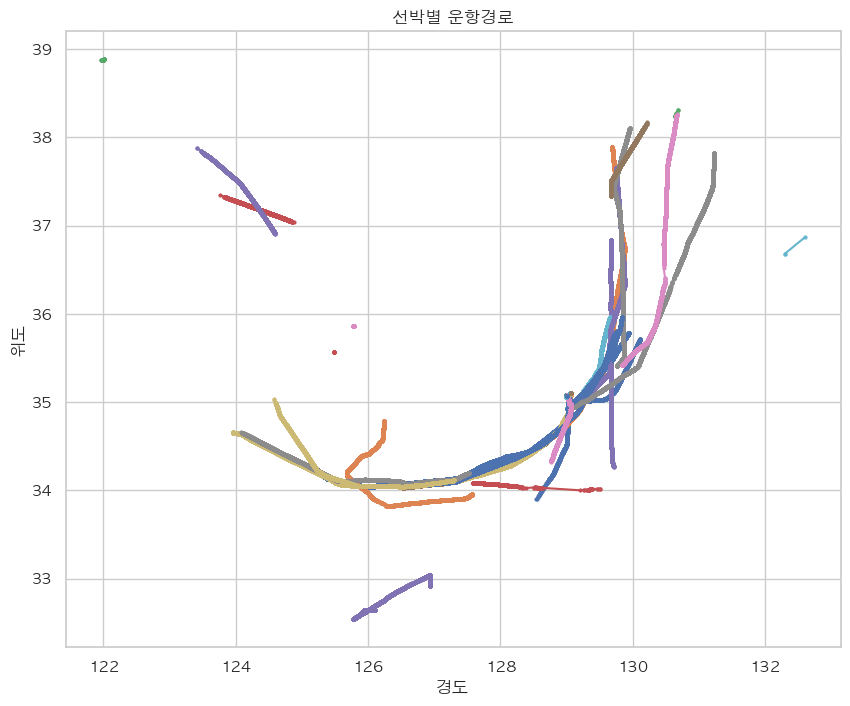

In [23]:
# MMSI별 항로 시각화

plt.figure(figsize=(10, 8))
mmsi_list = df['mmsi'].unique()


for mmsi in mmsi_list:
    subset = df[df['mmsi'] == mmsi].sort_values('timestamp')
    plt.plot(subset['longitude'], subset['latitude'], marker='o', markersize=2, label=mmsi)

plt.title("선박별 운항경로")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.show()